In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from __future__ import division, print_function, absolute_import

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import numpy as np
import pymssql
import pandas as pd
import os

In [3]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj
from lsst.sims.utils import ObservationMetaData
from lsst.utils import getPackageDir

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [4]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(Om0=0.25, H0=73.)

In [5]:
from lsst.daf.persistence import DbAuth
import lsst.pex.config as pexConfig

In [6]:
# %%timeit 
# Connect to DataBase
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()



In [7]:
# Quick test to check that this works
db.execute("""SELECT COUNT(*) FROM galaxy WHERE ra < 2 and ra > -2 and dec > -2 and dec < 2""")
totgals = db.fetchall()[0][0]
print('{0} million galaxies in base patch'.format(totgals/1e6))
db.execute("""SELECT COUNT(*) FROM galaxy WHERE ra < 2 and ra > -2 and dec > -2 and dec < 2 and redshift < 1.4""")
SNgals = db.fetchall()[0][0]
print('{0} million galaxies in base patch at redshifts less than 1.4'.format(SNgals/1e6))

13.758768 million galaxies in base patch
7.158432 million galaxies in base patch at redshifts less than 1.4


## Galaxies

In [8]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj
from lsst.sims.utils import ObservationMetaData

## probTable

In [9]:
query = """SELECT MIN(redshift) as minz, MAX(redshift) as maxz, 
           MIN(mass_stellar) as minM, MAX(mass_stellar) as maxM, 
           COUNT(*)FROM galaxy 
           where redshift <= 1.4 
           and ra > -2 and dec > -2 and ra < 2 and dec < 2"""

In [10]:
db.execute(query)
minz, maxz, minM, maxM, numGals = db.fetchall()[0]

In [11]:
print(minz, maxz, maxM, numGals, minM)

0.00645000021905 1.39999520779 68.9491577148 7158432 8.00000009349e-07


In [12]:
numBins = 14
maxredshift =1.4
zbinwidth = maxredshift / numBins
masswidth = (maxM - minM) / numBins

In [13]:
query = """SELECT g.zbin, SUM(g.mass_stellar) as TotMass FROM
           (SELECT FLOOR(redshift/{0}) AS zbin, mass_stellar 
           FROM galaxy 
           WHERE redshift <= {1} 
               AND ra > -2
               AND dec > -2 
               AND ra < 2 
               AND dec < 2) g 
            GROUP BY g.zbin 
            ORDER BY g.zbin   """.format(zbinwidth, maxredshift)

In [14]:
db.execute(query)

In [15]:
df = pd.DataFrame.from_records(db.fetchall(), columns=['zbin', 'TotMass'])

In [16]:
df.zbin = df.zbin.astype(np.int)

In [17]:
zvals = np.linspace(0., maxredshift, numBins)

In [18]:
df.dtypes

zbin         int64
TotMass    float64
dtype: object

In [ ]:
def totMassDF(db, numzBin, maxRedshift):
    
    zbinwidth = maxRedshift / numzBin
    query = """SELECT g.zbin, SUM(g.mass_stellar) as TotMass FROM
           (SELECT FLOOR(redshift/{0}) AS zbin, mass_stellar 
           FROM galaxy 
           WHERE redshift <= {1} 
               AND ra > -2
               AND dec > -2 
               AND ra < 2 
               AND dec < 2) g 
            GROUP BY g.zbin 
            ORDER BY g.zbin   """.format(zbinwidth, maxRedshift)
    db.execute(query)
    df = pd.DataFrame.from_records(db.fetchall(), columns=['zbin', 'TotMass'])
    df.zbin = df.zbin.astype(np.int)
    return df

In [19]:
gals = pd.read_csv('galdb.csv')

In [20]:
gals['zbin'] = gals.redshift // zbinwidth
gals.zbin = gals.zbin.astype(np.int)

In [21]:
gals.dtypes

id                int64
mass_stellar    float64
redshift        float64
ra              float64
dec             float64
zbin              int64
dtype: object

In [22]:
joined = pd.merge(gals[['id', 'redshift', 'zbin', 'mass_stellar']], 
                  df, how='inner', on='zbin') 

In [23]:
joined['discreteProb'] = joined['mass_stellar'] / joined['TotMass']

In [24]:
joined[['id', 'discreteProb']].to_csv('prob_table_fatboy.csv', index=False)

In [25]:
!head prob_table_fatboy.csv

id,discreteProb
2638779,5.13327484172e-07
5796944,4.03083118733e-07
876494,1.25705161462e-06
646728,1.46857156737e-06
196618,1.72303323581e-05
11612237,4.99115038685e-08
3479879,2.50250807804e-07
11598278,3.99147137678e-08
2632344,2.2189829087e-07


## Tests 

In [28]:
def subplot_ind(rows, cols, i):
    return (i // cols, i % cols)

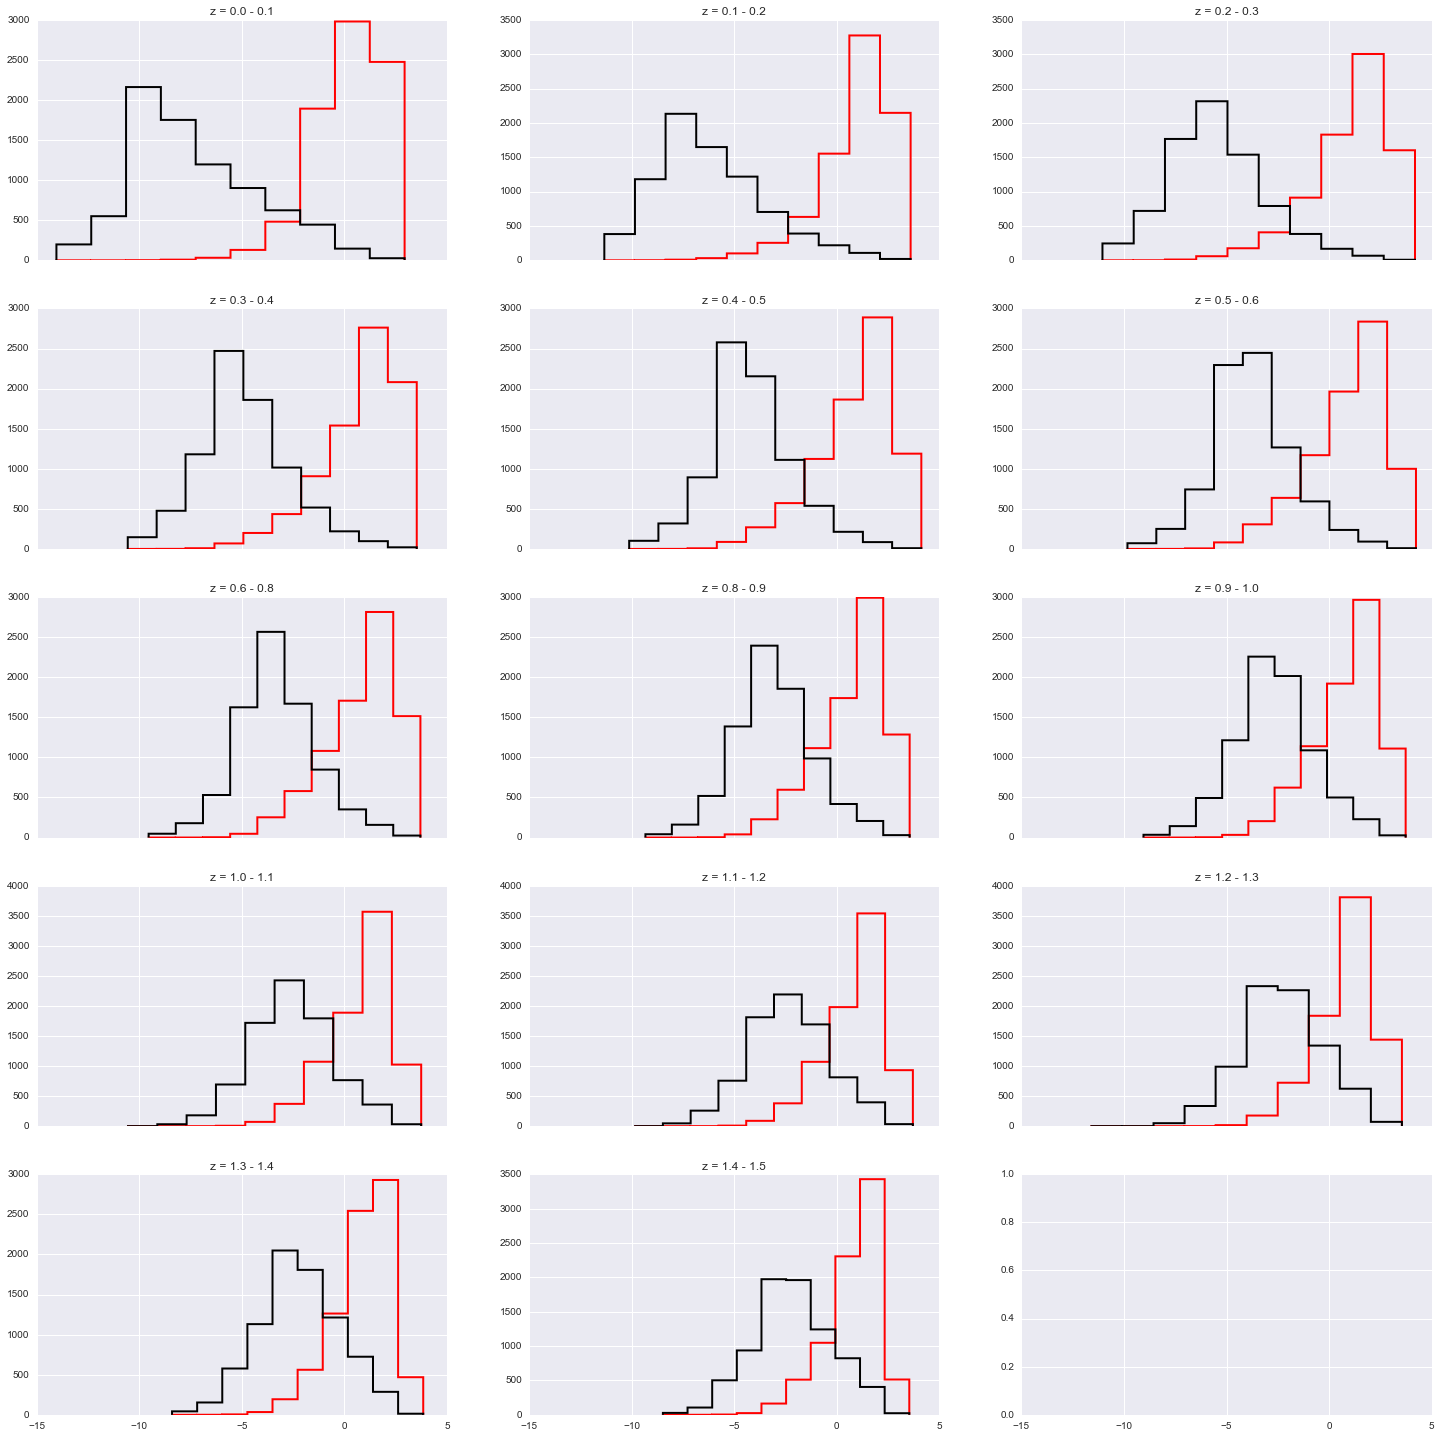

In [32]:
figrows = 5
figcols = 3
normedVal = True
numSN = 8000
fig, ax = plt.subplots(figrows, figcols, sharex=True, sharey=False, squeeze=True, figsize=(25, 25))
for i in range(numBins):
    try:
        sind = subplot_ind(figrows, figcols, i)
        ax[sind[0], sind[1]].set_title('z = {0:.1f} - {1:0.1f}'.format(zvals[i], zvals[i] + np.diff(zvals)[0]))
        ax[sind[0], sind[1]].hist(np.log(joined.query('zbin==@i').mass_stellar), weights=numSN * joined.query('zbin==@i').discreteProb, 
                                  histtype='step', lw=2., normed=normedVal, color='r')
        ax[sind[0], sind[1]].hist(np.log(joined.query('zbin==@i').mass_stellar),
                                  weights = numSN * np.ones(len(joined.query('zbin==@i').mass_stellar))/len(joined.query('zbin==@i')),
                                  histtype='step', lw=2., normed=normedVal, color='k')
        # ax[sind[0], sind[1]].axhline(df.query('zbin==@i').uprob.astype('float').unique()[0], ls='dotted')
        #ax[sind[0], sind[1]].set_xscale('log')
        #ax[sind[0], sind[1]].set_ylim(0, 100)
    except IndexError:
        break 

In [30]:
fig.savefig('hostMasses.png')

In [34]:
joined.columns

Index([u'id', u'redshift', u'zbin', u'mass_stellar', u'TotMass',
       u'discreteProb'],
      dtype='object')

redshift > 0.0 and redshift < 0.1
21949
redshift > 0.1 and redshift < 0.2
144655
redshift > 0.2 and redshift < 0.3
296921
redshift > 0.3 and redshift < 0.4
444037
redshift > 0.4 and redshift < 0.5
551192
redshift > 0.5 and redshift < 0.6
588683
redshift > 0.6 and redshift < 0.8
1185754
redshift > 0.8 and redshift < 0.9
604166
redshift > 0.9 and redshift < 1.0
634535
redshift > 1.0 and redshift < 1.1
676491
redshift > 1.1 and redshift < 1.2
695853
redshift > 1.2 and redshift < 1.3
677179
redshift > 1.3 and redshift < 1.4
637017


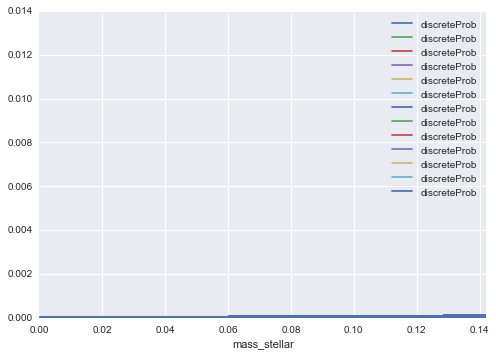

In [37]:
fig, ax = plt.subplots()
for i in range(numBins-1):
    s = 'redshift > {0:.1f} and redshift < {1:0.1f}'.format(zvals[i], zvals[i] + np.diff(zvals)[0])
    #print(joined_second.query(s).mass_stellar.size)
    print(s)
    l = '{0:.1f}-{1:0.1f}'.format(zvals[i], zvals[i] + np.diff(zvals)[0])

    print(len(joined.query(s)))
    joined.query(s).plot('mass_stellar', 'discreteProb', ax=ax)



(0.0, 0.012539542312440557)

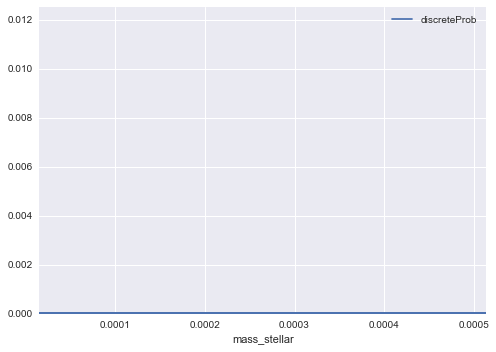

In [45]:
fig, ax = plt.subplots()
joined.query('redshift < 0.1').plot('mass_stellar', 'discreteProb', ax=ax)
# ax.set_ylim(0., joined.discreteProb.max())


In [48]:
joined.query('discreteProb > 0.01')

,id,redshift,zbin,mass_stellar,TotMass,discreteProb
7150744,23,0.079003,0,18.793427,1498.733051,0.012540
7150752,151,0.078980,0,15.367709,1498.733051,0.010254


In [39]:
test = joined.query('redshift < 0.1')

In [43]:
1.0 / test.mass_stellar.sum()

0.00066723023091600886

In [54]:
joined.query('mass_stellar > 30')[['mass_stellar','TotMass']]

,mass_stellar,TotMass
2202,30.794590,109045.005856
12497,33.471626,109045.005856
18067,57.975323,109045.005856
19927,61.664181,109045.005856
32698,30.255306,109045.005856
40061,33.471626,109045.005856
41312,30.573492,109045.005856
41639,57.975323,109045.005856
45328,42.111847,109045.005856
53016,31.651009,109045.005856


In [41]:
test.discreteProb / test.mass_stellar

7136483    0.000667
7136484    0.000667
7136485    0.000667
7136486    0.000667
7136487    0.000667
7136488    0.000667
7136489    0.000667
7136490    0.000667
7136491    0.000667
7136492    0.000667
7136493    0.000667
7136494    0.000667
7136495    0.000667
7136496    0.000667
7136497    0.000667
7136498    0.000667
7136499    0.000667
7136500    0.000667
7136501    0.000667
7136502    0.000667
7136503    0.000667
7136504    0.000667
7136505    0.000667
7136506    0.000667
7136507    0.000667
7136508    0.000667
7136509    0.000667
7136510    0.000667
7136511    0.000667
7136512    0.000667
             ...   
7158402    0.000667
7158403    0.000667
7158404    0.000667
7158405    0.000667
7158406    0.000667
7158407    0.000667
7158408    0.000667
7158409    0.000667
7158410    0.000667
7158411    0.000667
7158412    0.000667
7158413    0.000667
7158414    0.000667
7158415    0.000667
7158416    0.000667
7158417    0.000667
7158418    0.000667
7158419    0.000667
7158420    0.000667


In [49]:
joined.head()

,id,redshift,zbin,mass_stellar,TotMass,discreteProb
0,2638779,0.407043,4,0.055976,109045.005856,5.133275e-07
1,5796944,0.477448,4,0.043954,109045.005856,4.030831e-07
2,876494,0.497270,4,0.137075,109045.005856,1.257052e-06
3,646728,0.407099,4,0.160140,109045.005856,1.468572e-06
4,196618,0.484248,4,1.878882,109045.005856,1.723033e-05
